In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_velocity import decay
import numpy as np
import pandas as pd
import gc

In [3]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()
data.load_pseudotime(do_rho=False)

# Copy cell cycle time to main object
data.all_data.obs['program_cc_time'] = 0
for _, e in data.expt_data.items():
    data.all_data.obs.loc[e.obs_names, 'program_cc_time'] = e.obs['program_cc_time']

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [23]:
#FIGURE_4_GENES = ["YKR039W", "YOR063W"]
#FIGURE_5_GENES = ["YGR109C", "YDR224C", "YPR119W", "YGR108W"]

FIGURE_4_GENES = ["YKR039W"]
FIGURE_5_GENES = ["YGR108W", "YDR224C"]

if True or 'cell_cycle_window_decay' not in data.expt_data[(2, "fpr1")].varm:
    for k in data.expts:
        _decay = data.decay_data(*k)

        for vark in ['rapamycin_window_decay', 'cell_cycle_window_decay']:
            data.expt_data[k].varm[vark] = _decay.varm[vark]
            data.expt_data[k].varm[vark + "_se"] = _decay.varm[vark + "_se"]
            data.expt_data[k].uns[vark] = _decay.uns[vark]
            
        for vark in ['rapamycin_decay', 'rapamycin_decay_se', 'cell_cycle_decay', 'cell_cycle_decay_se']:
            data.expt_data[k].var[vark] = _decay.var[vark].copy()
            
        _idx = [_decay.var_names.get_loc(x) for x in FIGURE_5_GENES + FIGURE_4_GENES]
        
        data.expt_data[k].obsm['FIG5_EXPR'] = _decay.X[:, _idx]
        data.expt_data[k].obsm[f'FIG5_{RAPA_VELO_LAYER}'] = _decay.layers[RAPA_VELO_LAYER][:, _idx]
        data.expt_data[k].obsm[f'FIG5_{CC_VELO_LAYER}'] = _decay.layers[CC_VELO_LAYER][:, _idx]

        del _decay
        gc.collect()
        
    data.decay_data_all()

Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_fpr1.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_fpr1.h5ad


<ipython-input-24-e3c86ba00457>:48: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(arr), np.nanmax(arr)


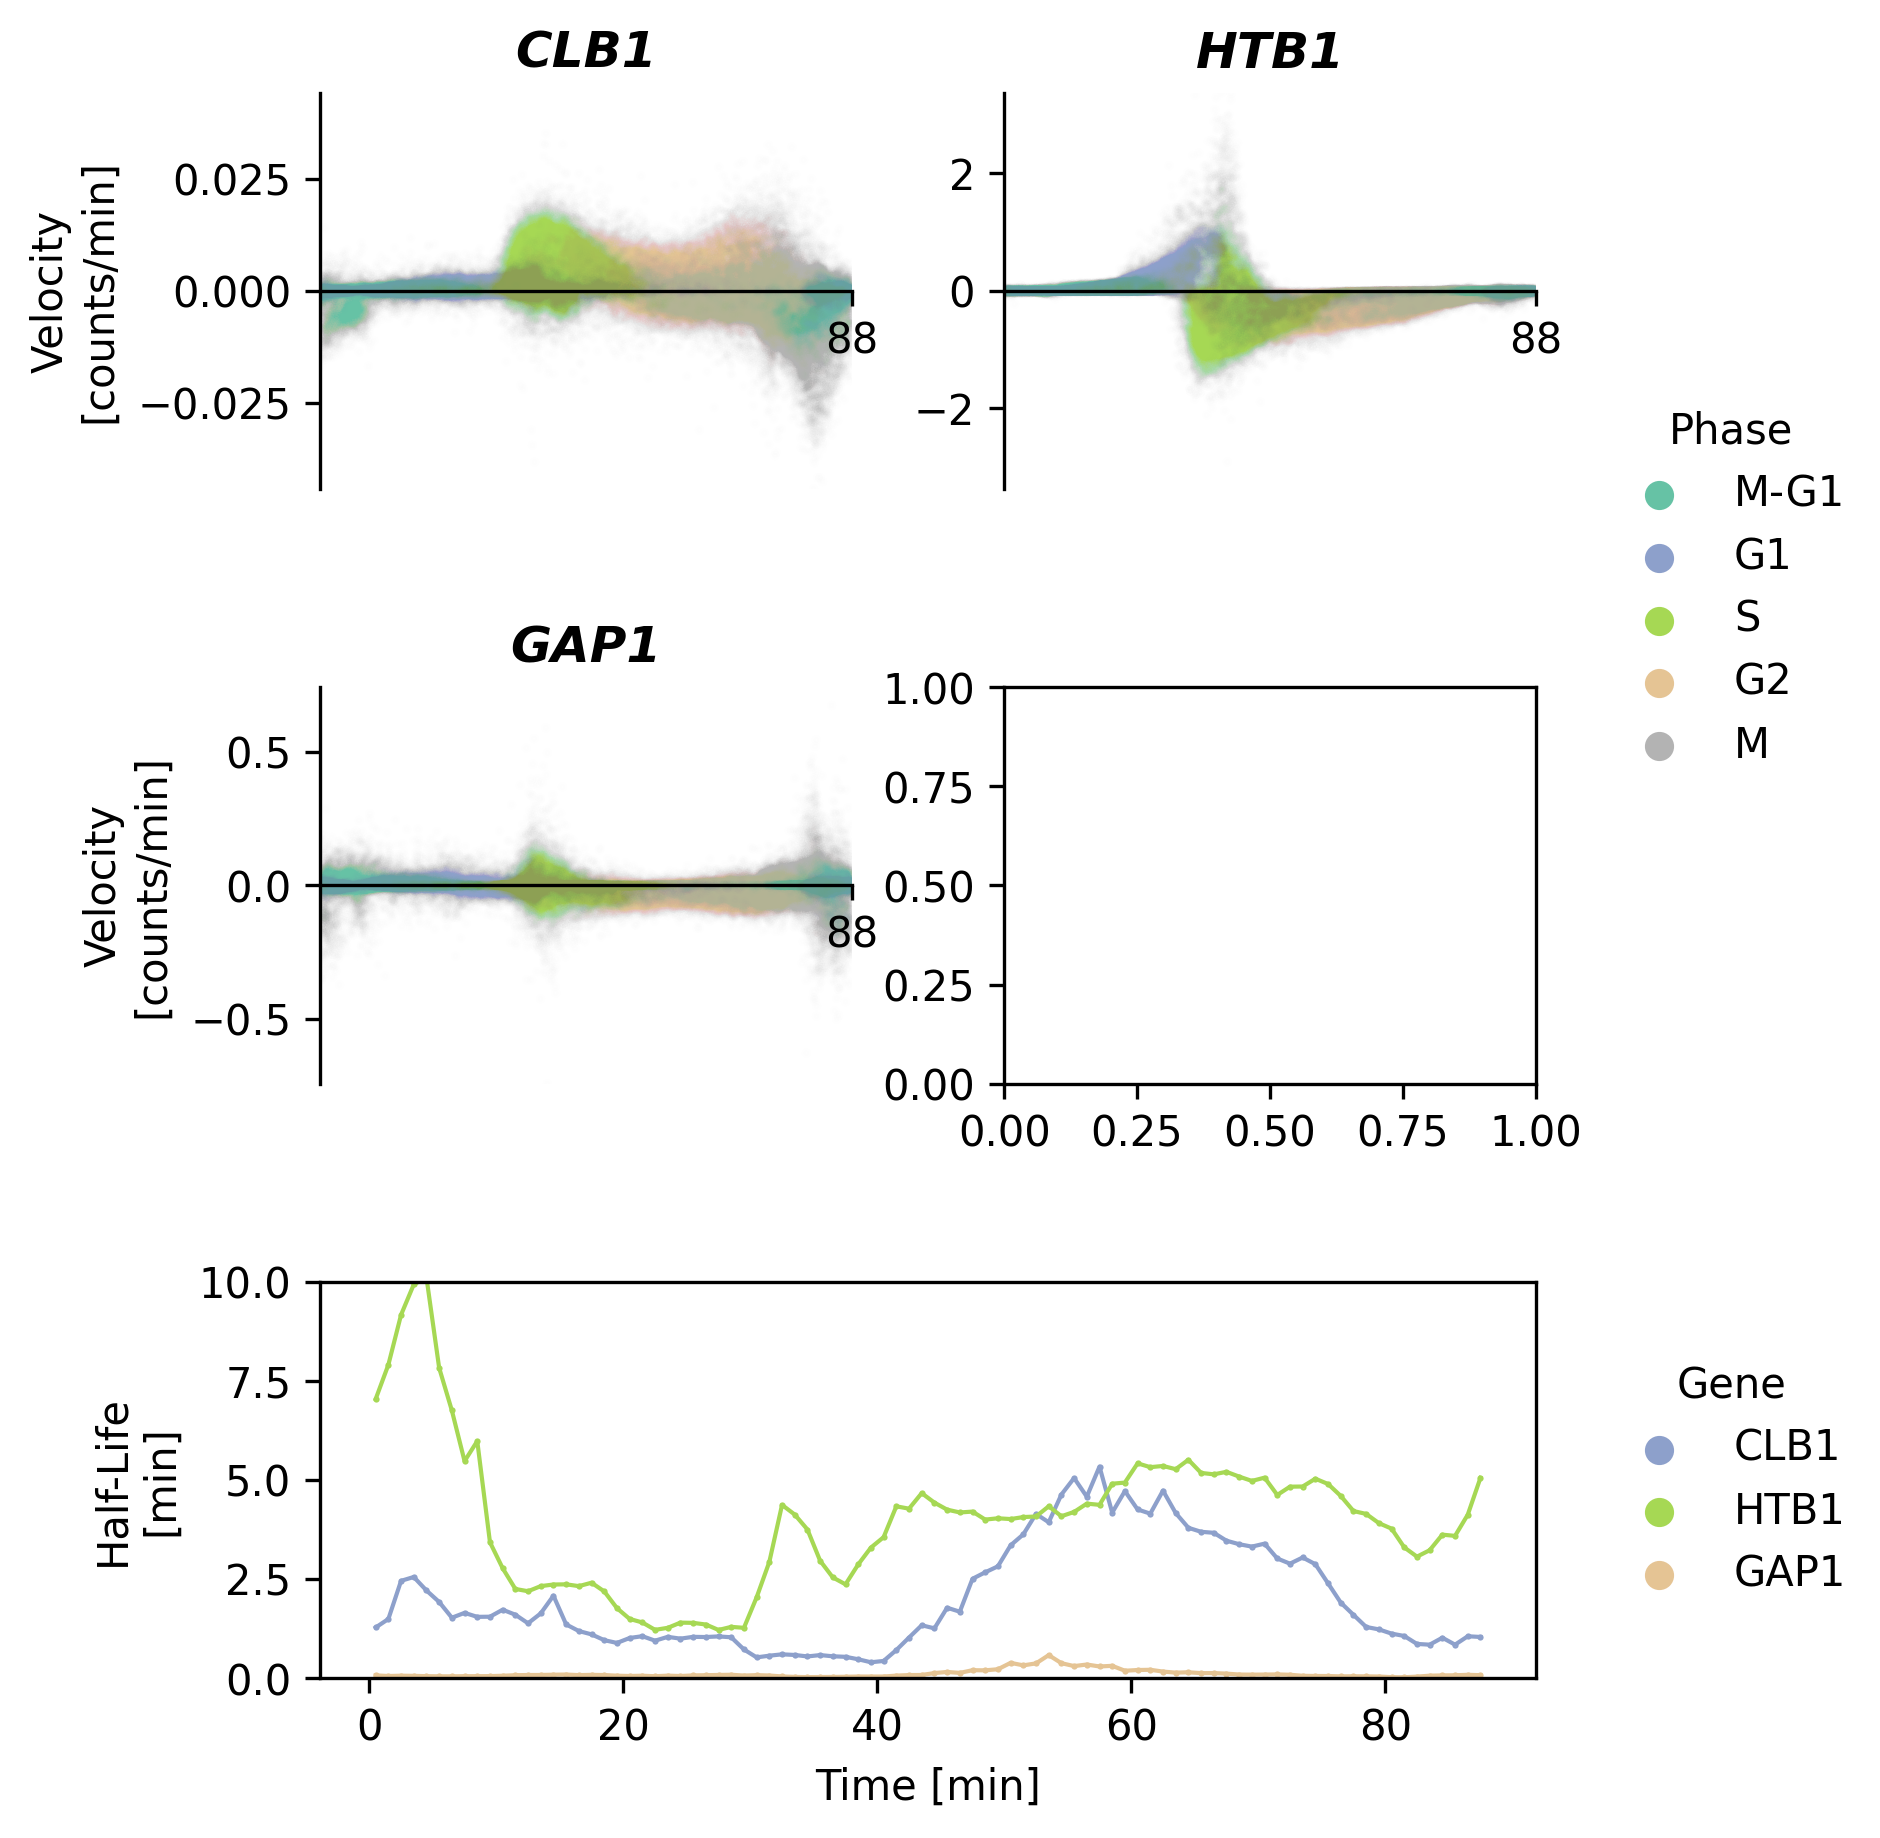

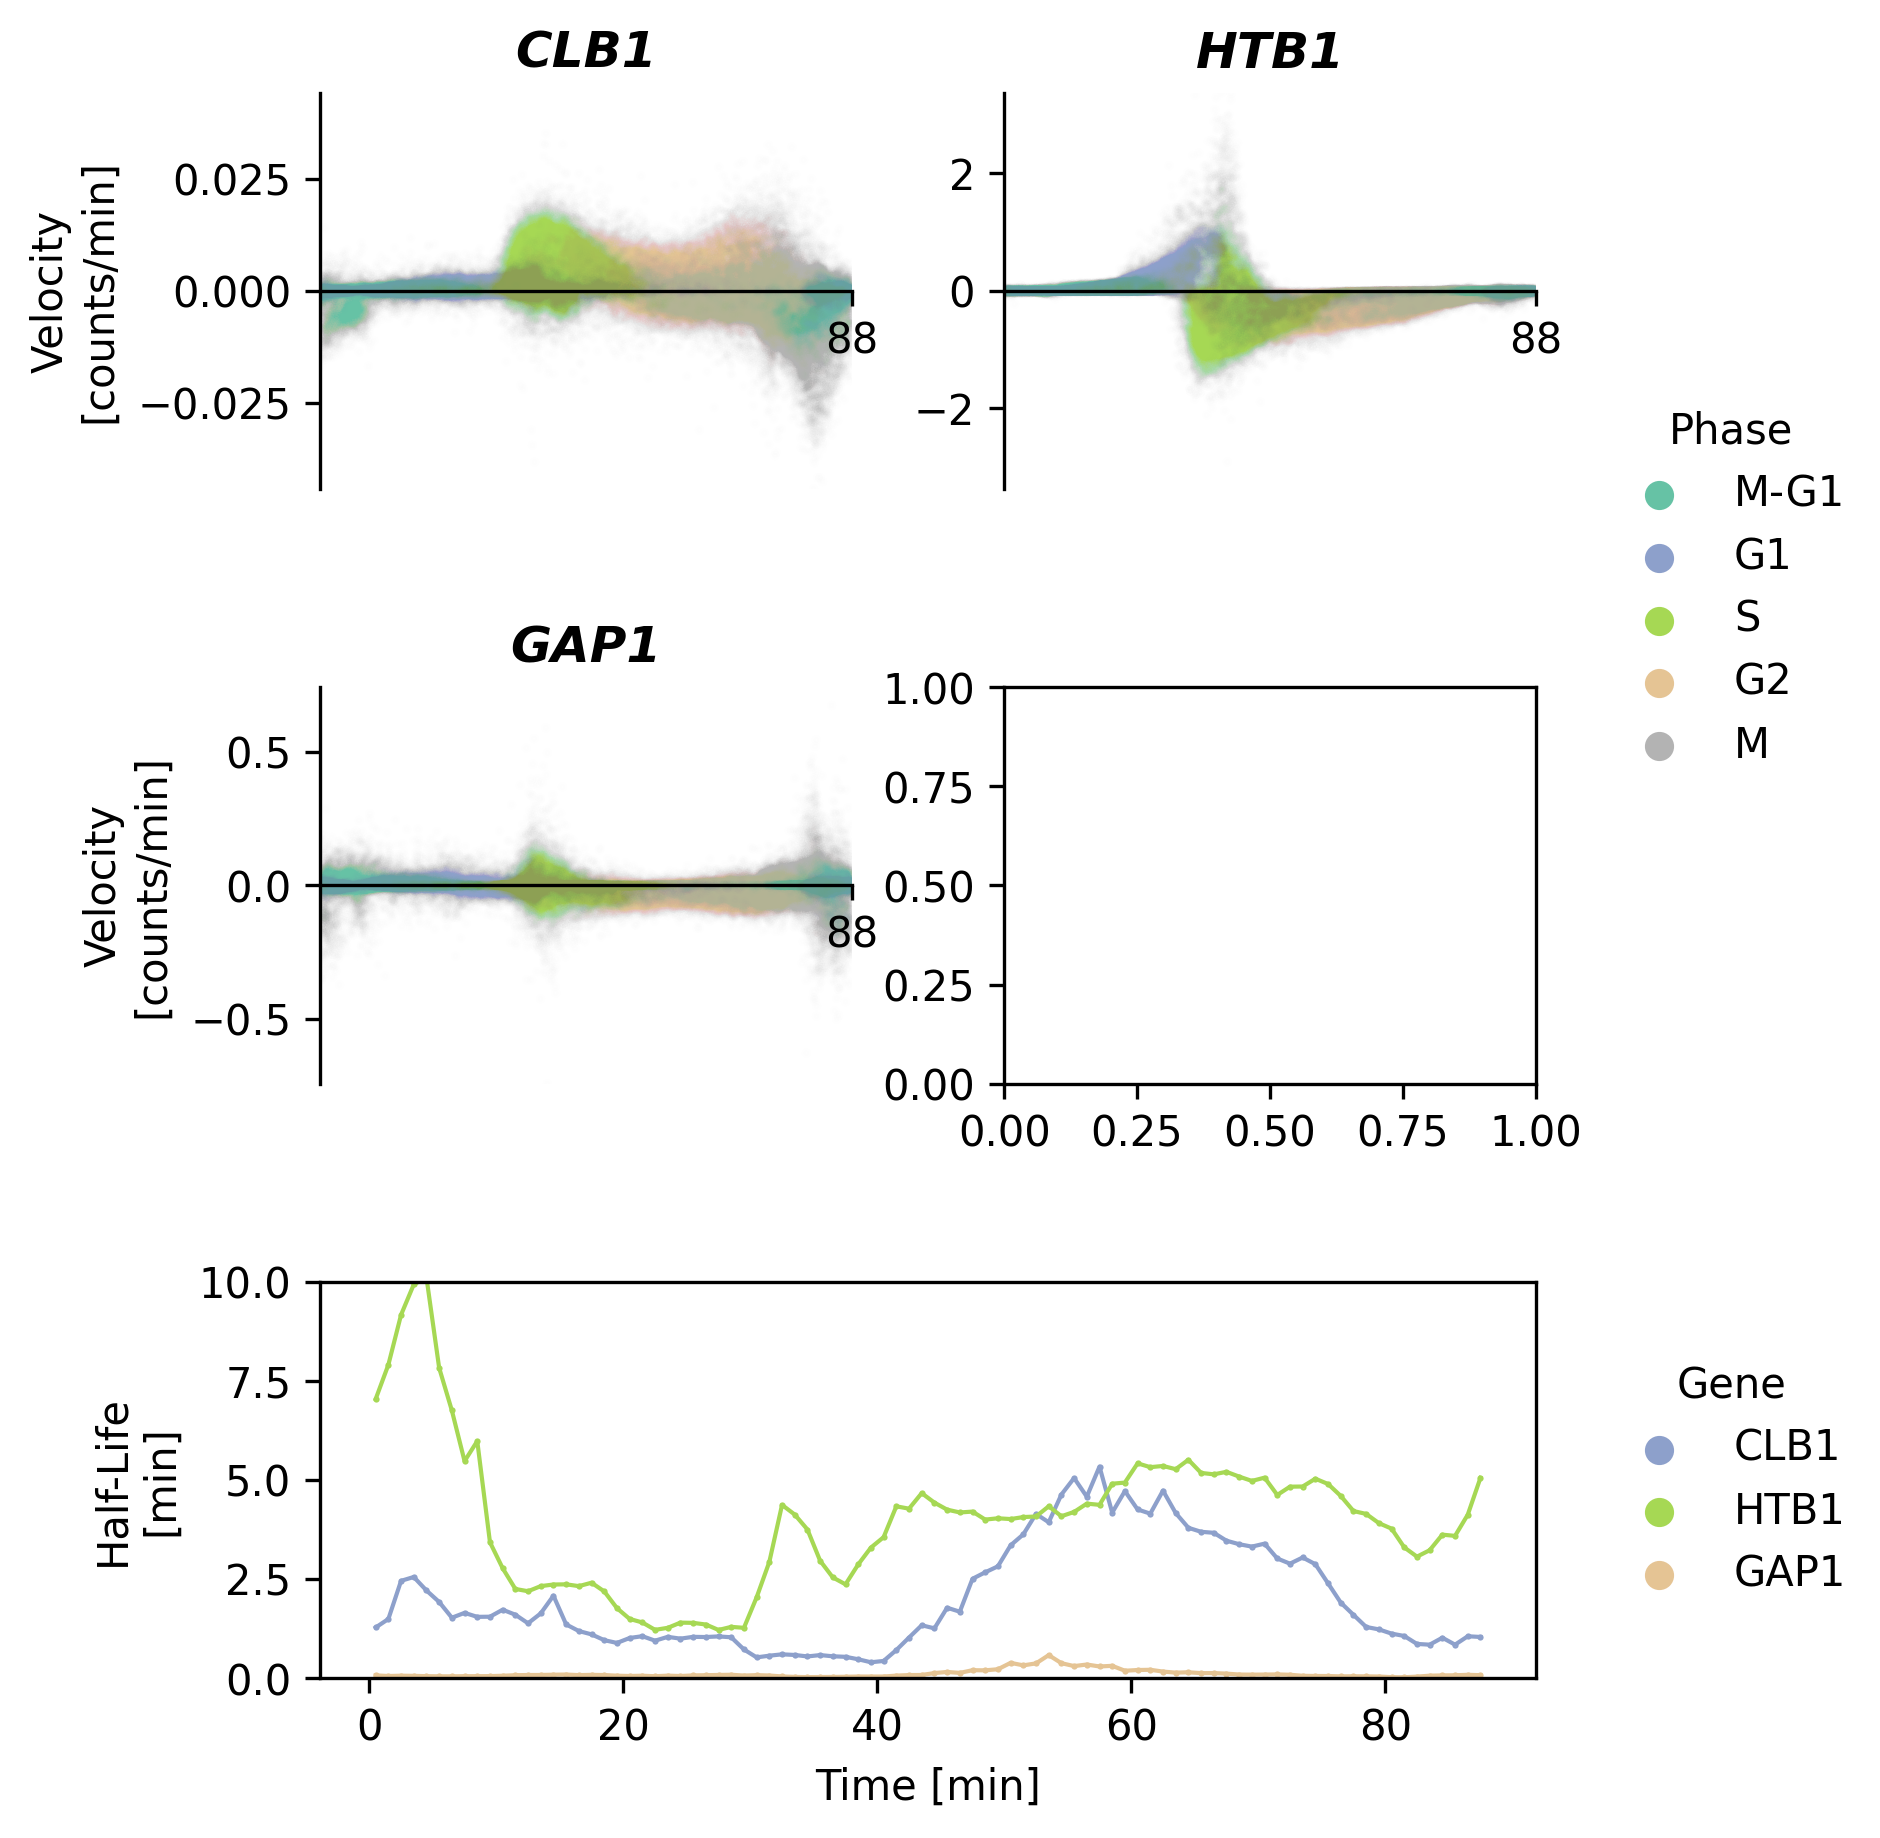

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import inferelator_velocity as ifv

rgen = np.random.default_rng(100)

rep_colors = ['darkslateblue', 'darkgoldenrod']

panel_labels = {'schematic': "A",
                'expr_1': "B",
                'velocity_1': "C",
                'decay_1': "D",
                'decaytime_1': "E"}

layout = [['expr', 'velo', 'cc_cbar'],
          ['g1_expr', 'g1_velo', 'cc_cbar']]


def plot_figure_5(data, save=True):
    rgen = np.random.default_rng(100)

    rep_colors = ['darkslateblue', 'darkgoldenrod', 'black']

    panel_labels = {'velocity_1': "A",
                    'decaytime': "B"}

    #layout = [['velocity_1', '.', 'velocity_2', 'cc_lgd'],
    #          ['velocity_3', '.', 'velocity_4', 'cc_lgd'],
    #          ['velocity_5', '.', 'velocity_6', 'cc_lgd'],
    #          ['decaytime', 'decaytime', 'decaytime', 'gene_lgd']]
    
    layout = [['velocity_1', '.', 'velocity_2', 'cc_lgd'],
              ['velocity_3', '.', 'velocity_4', 'cc_lgd'],
              ['decaytime', 'decaytime', 'decaytime', 'gene_lgd']]

    fig_refs = {}

    fig, axd = plt.subplot_mosaic(layout,
                                  gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                                   height_ratios=[1, 1, 1],
                                                   wspace=0.25, hspace=0.5), 
                                  figsize=(6, 7), dpi=300)

    def _minmax(arr):
        return np.nanmin(arr), np.nanmax(arr)

    def _minmax_list(lst):
        return min(l[0] for l in lst), max(l[1] for l in lst)

    def _get_limits(layer, symmetric=False):
        limits = {g: _minmax_list(
            [_minmax(data.expt_data[(j, k)].obsm[layer][:, [x == g for x in FIGURE_5_GENES + FIGURE_4_GENES]]) for j in range(1, 3) for k in ["WT"]]
        )
        for g in FIGURE_5_GENES + FIGURE_4_GENES}

        if not symmetric:
            return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
        else:
            return {g: (-1 * np.max(np.abs(v)), np.max(np.abs(v))) for g, v in limits.items()}

    def _get_halflife_limits(decay_key='cell_cycle_window_decay', se_key='cell_cycle_window_decay', max_halflife=120):
        limits = {g: _minmax_list([_minmax(_halflife(data.expt_data[(j, k)].varm[decay_key][data.expt_data[(j, k)].var_names == g, :].flatten() -
                                                     data.expt_data[(j, k)].varm[se_key][data.expt_data[(j, k)].var_names == g, :].flatten()))
                                 for j in range(1, 3) 
                                 for k in ["WT"]]) for g in FIGURE_5_GENES + FIGURE_4_GENES}
        return {g: (0, np.ceil(min(max_halflife, v[1]))) for g, v in limits.items()}
           
    expr_limits = _get_limits('FIG5_EXPR')
    velocity_limits = _get_limits(f'FIG5_{CC_VELO_LAYER}', symmetric=True)
    halflife_limits = _get_halflife_limits()

    for a in ['cc_lgd']:
        axd[a].axis('off')

    def _replot_axes(ax):
        ax.spines['left'].set_position(('axes', 0.0))
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0.0))
        ax.spines['top'].set_color('none')

    def _gene_data(gene, layer='FIG5_EXPR'):    
        g_data = np.concatenate([data.expt_data[(i, "WT")].obsm[layer][:, [gene == x for x in FIGURE_5_GENES + FIGURE_4_GENES]].flatten()
                                 for i in range(1, 3)])
        t_data = np.concatenate([data.expt_data[(i, "WT")].obs[CC_TIME_COL].values
                                 for i in range(1, 3)])
        
        t_data[t_data < 0] = t_data[t_data < 0] + CC_LENGTH
        t_data[t_data > CC_LENGTH] = t_data[t_data > CC_LENGTH] - CC_LENGTH

        pools = np.concatenate([data.expt_data[(i, "WT")].obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values
                                for i in range(1, 3)])

        return g_data, t_data, pools

    def _decay_data(gene):
        decays = [data.expt_data[(i, "WT")].varm['cell_cycle_window_decay'][data.expt_data[(i, "WT")].var_names == gene, :].flatten()
                  for i in range(1, 3)]
        times = data.expt_data[(1, "WT")].uns['cell_cycle_window_decay']['times']
        
        decays.append(data.all_data.varm['cell_cycle_window_decay'][data.all_data.var_names == gene, :].flatten())

        return decays, times

    for i, g in enumerate(FIGURE_5_GENES + FIGURE_4_GENES):
        velocity_data, time_data, color_data = _gene_data(g, layer=f'FIG5_{CC_VELO_LAYER}')
        #velocity_data, time_data, color_data = _gene_data(g, layer=f'FIG5_EXPR')

        overplot_shuffle = np.arange(velocity_data.shape[0])
        rgen.shuffle(overplot_shuffle)

        time_data = time_data[overplot_shuffle]
        color_data = color_data[overplot_shuffle]
        velocity_data = velocity_data[overplot_shuffle]

        ### PANEL A ###
        b_ref = "velocity_" + str(i + 1)
        fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.0025, 
                                             s=2) 
        
        axd[b_ref].set_xlim([0, CC_LENGTH])
        axd[b_ref].set_xticks([CC_LENGTH])
        axd[b_ref].set_ylim(*velocity_limits[g])
        axd[b_ref].set_ylabel("Velocity\n[counts/min]") if i % 2 == 0 else None
        axd[b_ref].set_xlabel("Time [min]", labelpad=10) if i > 4 == 0 else None
        axd[b_ref].set_title(data.gene_common_name(g), 
                             fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})
        _replot_axes(axd[b_ref])
        
        decays, times = _decay_data(g)
        
        axd['decaytime'].plot(
            times, 
            _halflife(decays[2].ravel()), 
            marker=".", 
            linestyle='-', 
            linewidth=1.0, 
            markersize=1, 
            c=cc_palette()[i + 1] if i < 4 else gene_category_palette()[i - 4],
            alpha=1
        )
            
    #axd['decaytime'].set_xlim([5, CC_LENGTH - 5])
    axd['decaytime'].set_ylim([0, 10])
    axd['decaytime'].set_ylabel("Half-Life\n[min]")
    axd['decaytime'].set_xlabel("Time [min]")

    fig_refs['cc_lgd'] = add_legend(axd['cc_lgd'], 
                                    cc_palette(), 
                                    CC_COLS,
                                    title="Phase")
    
    fig_refs['gene_lgd'] = add_legend(axd['gene_lgd'], 
                                      cc_palette()[1:] + gene_category_palette()[:2], 
                                      [data.gene_common_name(x) for x in FIGURE_5_GENES + FIGURE_4_GENES],
                                      title="Gene")
    
    if save:
        fig.savefig(FIGURE_5_FILE_NAME + ".png", facecolor='white', bbox_inches='tight')
    
    return fig

plot_figure_5(data)

In [ ]:
def _plot_gene_time(gene, tmin, tmax):
    fig, ax = plt.sublplots(1, 1)
    
    overplot_shuffle = np.arange(velocity_data.shape[0])
    rgen.shuffle(overplot_shuffle)

    time_data = time_data[overplot_shuffle]
    color_data = color_data[overplot_shuffle]
    velocity_data = velocity_data[overplot_shuffle]

    ### PANEL A ###
    b_ref = "velocity_" + str(i + 1)
    fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                         y=velocity_data,
                                         c=color_data,
                                         alpha=0.1, 
                                         s=2) 

    axd[b_ref].set_xlim([0, CC_LENGTH])
    axd[b_ref].set_xticks([CC_LENGTH])
    axd[b_ref].set_ylim(*velocity_limits[g])
    axd[b_ref].set_ylabel("Velocity\n[counts/min]") if i % 2 == 0 else None
    axd[b_ref].set_xlabel("Time [min]", labelpad=10) if i > 4 == 0 else None
    axd[b_ref].set_title(data.gene_common_name(g), 
                         fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})
    _replot_axes(axd[b_ref])
    